<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Avanzados en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Review of Linear Models</div><br>
    <div style="font-size: large">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div><br></div><hr>
</div>


**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [7]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, lars_path, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

from Utils import plot_dataset, plot_linear_model, evaluate_linear_model
from Utils import plot_dataset_clas, plot_linear_model_clas, fun_cross_entropy, grad_cross_entropy
from Utils import generate_bv_example
from Utils import fit_polylinear_regression, pred_polylinear_regression, plot_polylinear_model
from Utils import plot_contour_lp, plot_contour_l1_l2, plot_contour_linear_lp


matplotlib.rc("figure", figsize=(15, 5))
seed = 123

# Multiple Linear Regression

In this case, $\mathcal{X} = \mathbb{R}^d$ and $\mathcal{Y} = \mathbb{R}$. The models are definded by the normal vector of the hyperplane and the intercept.

## First Example

### Dataset

This code generates and plots the dataset.
As it can be seen, the underlying (real) model behind the data is linear.

In [ ]:
n_pat = 50
n_dim = 3
noise = 0.5

np.random.seed(seed)

wm_r = np.random.randn(n_dim)
bm_r = np.random.randn()

xm = np.random.randn(n_pat, n_dim)
ym_r = xm @ wm_r + bm_r + noise * np.random.randn(n_pat)

plot_dataset(xm, ym_r)

<div class="qst">

* Can the linearity be distinguished also in the plot?

</div>

### 1-Dimensional Linear Models

A first approach to a multidimensional problem is to reduce it to a 1-dimensional problem by retaining only one of the features.
The code below trains one model per feature.

In [ ]:
for i in range(xm.shape[1]):
    xmi = xm[:,i].reshape(-1, 1)
    # Train a linear model over over feature i.
    model = LinearRegression(fit_intercept=True)
    model.fit(xmi, ym_r)
    w = model.coef_[0]
    b = model.intercept_

    plot_linear_model(xmi, ym_r, w, b)
    plt.show()

<div class="qst">

* Are the previous models optimal?
* Is this a good approach?

</div>

## Optimization

The following function computes the linear model, returning the value of the normal vector and the intercept.

In [ ]:
def multiple_linear_regression(X, y):
    # Build the extended data matrix.
    X_bar = np.column_stack((np.ones(X.shape[0]), X))
    # Compute the optimum w and b by multiplying the pseudo-inverse times y.
    w_bar = np.linalg.inv(X_bar.T @ X_bar) @ (X_bar.T @ y)
    # Extract w and b from the vector of extended weights.
    w = w_bar[1:]
    b = w_bar[0]

    return w, b

<div class="qst">

* Look carefully at the implementation. Does it coincide with the equation shown in the slides?

</div>

The following cell compares the true model with the estimated one.

In [ ]:
wm_e, bm_e = multiple_linear_regression(xm, ym_r)
plot_linear_model(xm, ym_r, wm_e, bm_e, w_r=wm_r, b_r=bm_r)

The following cell trains a linear model using `scikit-learn`.

In [ ]:
# Create the model using LinearRegression.
model = LinearRegression(fit_intercept=True)
# Train the model using fit.
model.fit(xm, ym_r)
# Extract the model parameters.
w = model.coef_
b = model.intercept_

plot_linear_model(xm, ym_r, w, b, w_r=wm_r, b_r=bm_r)

<div class="qst">

* Is this model equivalent to the one computed using the `multiple_linear_regression` function?

</div>

# Binary Linear Classification

In this case, $\mathcal{X} = \mathbb{R}^2$ and $\mathcal{Y} = \{-1, 1\}$ (this encoding makes simpler the prediction, only by taking the sign).
The models are definded by the normal vector of the hyperplane and the intercept.

## First Example

### Dataset

This code generates and plots the dataset.
The underlying (real) model behind the data is linear, in the sense that the best separation is provided by a linear border.

In [ ]:
n_pat = 50
noise = 0.5
sep = 3

np.random.seed(seed)

X1 = np.random.randn(n_pat, 2)
X2 = np.random.randn(n_pat, 2)
sep_dir = np.random.randn(2)
X = np.vstack((X1, X2 + sep * sep_dir / np.linalg.norm(sep_dir)))
y = np.append(- np.ones(n_pat), np.ones(n_pat))

plot_dataset_clas(X, y)

<div class="qst">

* Can this be distinguished also in the plot?
* Can this problem be solved linearly?
* What is the influence of the `sep` variable?

</div>

### Estimation

A first linear model can be fitted by hand.

In [ ]:
########################################
# The parameters of the linear model can be modified here.
# For simplicity, the model is defined by the angle (in degrees) and the intercept.
deg = 0
b = 0
########################################

angle = deg / 360.0 * 2 * np.pi
plot_linear_model_clas(X, y, [np.sin(angle), np.cos(angle)], b)

<div class="qst">

* What is the best model (e.g. looking at the accuracy) that can be obtained?

</div>

## Quality of the Model

The following cells change the parameters of the model over a grid and compare the resulting models using the accuracy.

In [ ]:
n_points = 31
deg_vec = np.linspace(0, 360, n_points)
ang_vec = deg_vec / 360.0 * 2 * np.pi
b_vec = np.linspace(-2, 2, n_points)

deg_mat, b_mat = np.meshgrid(deg_vec, b_vec, indexing="ij")
accs = np.zeros(deg_mat.shape)

for i_ang in range(len(ang_vec)):
    ang = ang_vec[i_ang]
    for i_b in range(len(b_vec)):
        b = b_vec[i_b]
        y_p = np.sign(X @ np.array([np.sin(ang), np.cos(ang)]) + b)
        accs[i_ang, i_b] = accuracy_score(y, y_p)

In [ ]:
label = "Acc"
ind = np.unravel_index(np.argmax(accs), accs.shape)
plt.pcolormesh(deg_mat, b_mat, accs, shading="gouraud")

deg_opt = deg_vec[ind[0]]
b_opt = b_vec[ind[1]]

plt.plot(deg_opt, b_opt, "r*")
plt.xlabel("$\\alpha$")
plt.ylabel("$b$")
plt.colorbar().ax.set_ylabel(label)
plt.show()
print("Maximum %s:\t%6.2f" % (label, accs.max()))
print("Optimal degree:\t%6.2f" % (deg_opt))
print("Optimal b:\t%6.2f" % (b))

<div class="qst">

* How many models have been evaluated?
* Is this efficient, or even scalable?

</div>

The following cell shows the dependence of the accuracy with respect to $b$.

In [ ]:
ang_opt = ang_vec[ind[0]]

n_points = 1000
b_vec = np.linspace(-5, 5, n_points)

accs = np.zeros(n_points)
for i_b in range(len(b_vec)):
    b = b_vec[i_b]
    y_p = np.sign(X @ np.array([np.sin(ang_opt), np.cos(ang_opt)]) + b)
    accs[i_b] = accuracy_score(y, y_p)

plt.plot(b_vec, accs, "-")
plt.xlabel("$b$")
plt.ylabel("Acc")
plt.show()

<div class="qst">

* What is the problem of this measure?
* Is it continuous, or there are "jumps"?

</div>

## Training a Regression Linear Model

A first approach to linear classifiers is to train a regression linear model over the labels.

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
plot_linear_model_clas(X, y, model.coef_, model.intercept_)

<div class="qst">

* Is this model optimal?

</div>

### An Asymmetric Dataset

The problem of this approach can be clearly seen with an asymmetric dataset, where one class extends over a larger region than the other. The cell below generates such a dataset.

In [ ]:
n_pat = 50
noise = 0.5
scale = 15

np.random.seed(seed)

X1 = np.random.randn(n_pat, 2)
X2 = np.random.randn(n_pat, 2) * [scale, 1]
sep_dir = [1.5 * scale, 0]
X_a = np.vstack((X1, X2 + sep_dir))
y_a = np.append(- np.ones(n_pat), np.ones(n_pat))

plot_dataset_clas(X_a, y_a)

The following cell trains a linear regression model over the asymmetric dataset.

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X_a, y_a)
plot_linear_model_clas(X_a, y_a, model.coef_, model.intercept_)

<div class="qst">

* Is this model optimal?
* Can a better model be found?

</div>

## Optimization

### Using Gradient Descent

A simple gradient descent can be used to maximize the likelihood and, hence, find the optimum parameters.

In order to do so, it uses the `grad_cross_entropy` function, defined in the module `Utils`.
This function first converts the labels to $\mathcal{Y} = \{0, 1\}$, and then it computes the gradient.

In [ ]:
def logistic_regression(X, y, max_iter=1000, eta=1e-2, evolution=False):
    X_bar = np.column_stack((np.ones(X.shape[0]), X))
    w_bar = np.zeros(X_bar.shape[1])

    if evolution:
        evo = np.zeros(max_iter)
    for i in range(max_iter):
        w_bar = w_bar - eta * grad_cross_entropy(X_bar, y, w_bar)
        if evolution:
            evo[i] = fun_cross_entropy(X_bar, y, w_bar)

    w = w_bar[1:]
    b = w_bar[0]
    
    if evolution:
        return w, b, evo
    else:
        return w, b

<div class="qst">

* Does the previous implementation match the equation shown in the slides?

</div>

The cells below estimate the logistic regression models for the previous datasets.

In [ ]:
w, b, evolution = logistic_regression(X, y, evolution=True)
plot_linear_model_clas(X, y, w, b)

In [ ]:
w, b = logistic_regression(X_a, y_a)
plot_linear_model_clas(X_a, y_a, w, b)

<div class="qst">

* Is this approach better than the regression models above? Why?

</div>

The evolution of the gradient descent method can also be plotted, to see how this algorithm converges.

In [ ]:
plt.semilogy(evolution)
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.title("Convergence of the Gradient Descent")
plt.show()

### Using `scikit-learn`

A linear logistic regression model can also be trained using `scikit-learn`, in particular creating a model with `LogisticRegression` and training it with the `fit` function.

In [ ]:
model = LogisticRegression(fit_intercept=True, solver="lbfgs")
model.fit(X, y)
plot_linear_model_clas(X, y, model.coef_[0], model.intercept_)

In [ ]:
model = LogisticRegression(fit_intercept=True, solver="lbfgs")
model.fit(X_a, y_a)
plot_linear_model_clas(X_a, y_a, model.coef_[0], model.intercept_)

<div class="qst">

* Are these model equivalent to the ones computed using the `logistic_regression` function?

</div>

# Regularized Linear Models

## Bias–Variance Illustration

The following cell generates an illustration of the bias–variance concepts.
Models of different complexity are trained several times over difference samples of the same problem, and then they are used to predict over the same test set.
This allows to see the difference between the average of the predictions of a certain model and the real target (*bias*) and the variability of such predictions (*variance*).

In [ ]:
dists, preds, real = generate_bv_example()

plt.boxplot(preds[:, :, 0].T, showfliers=False)
plt.plot([1, len(preds)], [real[0]] * 2, ":k", label="Target")

plt.title("Illustration of Bias-Variance")
labels = ["Model %02d" % i for i in range(1, len(preds) + 1)]
plt.xticks(range(1, len(preds) + 1), labels, rotation=45)
plt.yticks([])
plt.ylabel("Prediction")
plt.legend()
plt.axis("tight")
plt.show()

<div class="qst">

* Which models have more variance? Why?
* Which models have more bias? Why?

</div>

## The Need of Regularization

In this section, a 1-dimensional problem is solved by generating polynomial features.
In particular, instead of predicing $y$ using only $x$, it will be predicted using $x$, $x^2$, $x^3$...
The number of such features is obviously related with the complexity of the model.

### Dataset

The dataset is a deterministic function $y = x^2$ plus some noise. The small number of patterns can lead to over-fitting easily.

In [ ]:
n_pat = 10
noise = 0.1

np.random.seed(seed)

x = np.linspace(-2, 2, n_pat)
y = np.square(x) + noise * np.random.randn(n_pat)

plot_dataset(x, y)

### Estimation with Polynomial Features

The following cell trains a linear model with the polynomial features $(x^1, x^2, \dotsc, x^d)$.

In [ ]:
########################################
# The degree of the model can be modified here.
degree = 1
########################################

model = fit_polylinear_regression(x, y, degree)
plot_polylinear_model(x, y, model)

<div class="qst">

* What happens when `degree = 1`?
* And when `degree = 10`?
* What is the optimal value of `degree`? Is it coherent with the way the dataset was generated?

</div>

### Regularization Path

A (discrete) regularization path can be built for the different values of the degree, and the train and test errors can be compared.
In order to do so, a large test set is generated to evaluate the model.

In [ ]:
x_tr = x
y_tr = y
x_te = np.linspace(-2, 2, 10 * n_pat)
y_te = np.square(x_te) + noise * np.random.randn(10 * n_pat)

degree_vec = np.arange(1, n_pat)

mse_tr = np.zeros(len(degree_vec))
mse_te = np.zeros(len(degree_vec))
for i_deg in range(len(degree_vec)):
    model = fit_polylinear_regression(x_tr, y_tr, degree_vec[i_deg])
    mse_tr[i_deg] = mean_squared_error(y_tr, pred_polylinear_regression(model, x_tr))
    mse_te[i_deg] = mean_squared_error(y_te, pred_polylinear_regression(model, x_te))

In [ ]:
plt.plot(degree_vec, mse_tr, label="Training")
plt.plot(degree_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogy(degree_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("Degree")
plt.ylabel("MSE")
plt.ylim([10**-3, 10**1])
plt.legend()
plt.show()

<div class="qst">

* What is the optimal value according to this regularization path?
* Does it match the intuition?

</div>

## Regularization Functions

The main regularization functions are based on different $\ell_p$ norms. In this section the level curves of the different norms can be plotted in order to help to understand their different effects.

### The $\ell_p$ Norm

The following cell shows the level curves of the $\ell_p$ norm in a $2$-dimensional context.
This means that all the points in the same level curve have the same $\ell_p$ norm.

In [ ]:
########################################
# The value of p can be modified here.
p = 2
########################################

plot_contour_lp(p=p)

<div class="qst">

* Change the value of `p` and try to appreciate the following properties:
    - If $p = 2$, the standard distance is recovered, hence the level curves are circles.
    - If $p \le 1$, the $\ell_p$ norm is non-differentiable, so corners should appear in the level curves.
      This corners are preferred when optimizing, producing the "sparsity".
    - If $p < 1$, the $\ell_p$ norm is non-convex, so the $\ell_1$ norm is the only convex and non-differentiable case.
    - The $\ell_\infty$ norm (`p = np.inf`) corresponds to the maximum element.
    - The $\ell_0$ norm corresponds to the count of non-zero elements.

</div>

### Combination of the $\ell_1$ Norm and the $\ell_2$ Norm

The following cell shows the level curves of the $\ell_1$ norm plus the $\ell_2$ norm, according to the formula:
$$
\lambda \| x \|_1 + (1 - \lambda) \| x \|_2 ,
$$
where $\lambda \in [0, 1]$ is encoded by the variable `l1_ratio`.

In [ ]:
########################################
# The value of the mixture between L1 and L2 can be modified here (it should be between 0 and 1).
l1_ratio = 0.5
########################################

plot_contour_l1_l2(l1_ratio=l1_ratio)

<div class="qst">

* Change the value of `l1_ratio` to check the transition from the $\ell_1$ to the $\ell_2$.
* Is the non-differentiable point always present? Therefore, will this regularizer produce sparsity?

</div>

## Linear Models and the $\ell_p$ Norm

In order to get an idea of the effect of each $\ell_p$ regularization, the following problem can be considered:
$$ \min_x f(\mathbf{w}) \quad \text{s.t. } \| \mathbf{w} \|_p \le 1 . $$
The function $f$ is in this case just the quadratic error of a linear model over the problem generated below.


The following cell defines the problem and plots the level curves of $f$ and the (approximate) solution of the unconstrained problem.

In [ ]:
n_pat = 100
noise = 0.1

np.random.seed(seed)

w = np.array([1, 2])
X = np.random.randn(n_pat, 2)
y = X @ w + noise * np.random.randn(n_pat)

plot_contour_linear_lp(X, y)

The following cell plots the level curves of $f$, the $\ell_p$-ball constraint and the (approximate) solution of the constrained problem.
This solution is given by the point where the smaller level curve (the more bluish) touches the $\ell_p$ ball.
It should be noticed that those solutions over the axis are sparse, since one of the components is zero.

In [ ]:
########################################
# The value of p can be modified here.
p = 2
########################################

plot_contour_linear_lp(X, y, p=p)

<div class="qst">

* Do sparse solutions appear more frequently for $p \le 1$? Is this related with the presence of corners?
* What happens when $p > 1$? Is there any sparsity?

</div>

## Ridge Regression

### Dataset

This cell generates a dataset with many uninformative features.

In [3]:
X, y = make_regression(random_state=seed, noise=5e0)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=1.0/3.0, random_state=seed)

alpha_vec = np.logspace(-3, 6)

### Regularization Path

An "empirical" regularization path can be estimated by changing the regularization parameter.

In [4]:
mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), X_tr.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Ridge(alpha_vec[i_alp])
    model.fit(X_tr, y_tr)
    mse_tr[i_alp] = mean_squared_error(y_tr, model.predict(X_tr))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(X_te))
    coefs[i_alp, :] = model.coef_

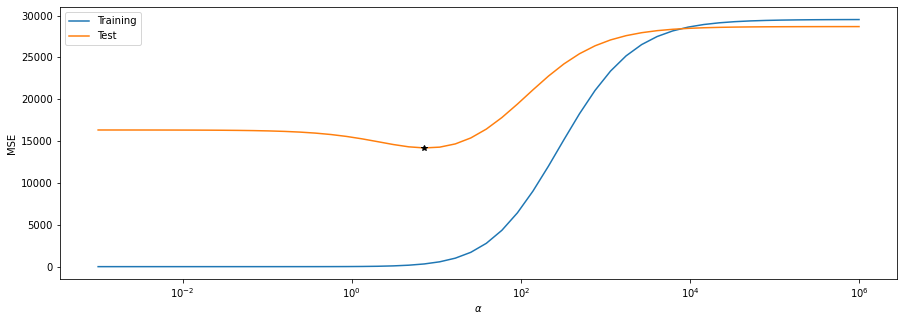

In [5]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()

The evolution of the coefficients illustrates the effect of the regularizer.

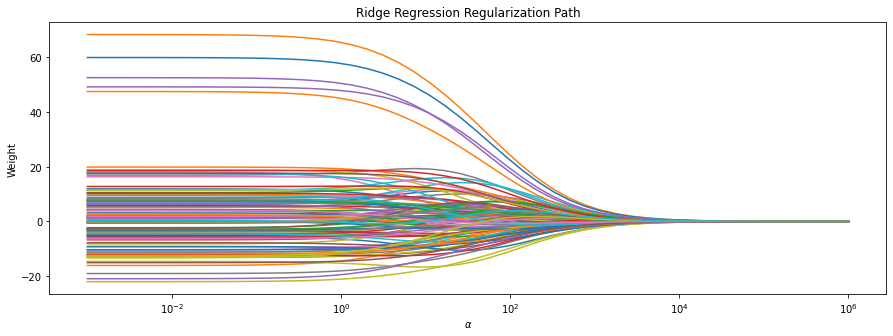

In [6]:
plt.semilogx(alpha_vec, coefs)

plt.title("Ridge Regression Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

<div class="qst">

* Is this evolution intuitive?
* Does it match the theory?

</div>

### Cross-Validation

An automatic search of the parameters can be done using the `GridSearchCV` function.

In [13]:
gs_rr = GridSearchCV(Ridge(), cv=5, param_grid={"alpha": alpha_vec})
gs_rr.fit(X_tr, y_tr)
print("Best Parameter: %.2g" % gs_rr.best_params_["alpha"])

Best Parameter: 26


<div class="qst">

* Is the optimal value similar to the one obtained above?

</div>

## Lasso

The same procedure can be repeated for the Lasso model, although there are specific ways of computing efficiently its regularization path.

### Regularization Path

In [9]:
mse_tr = np.zeros(len(alpha_vec))
mse_te = np.zeros(len(alpha_vec))
coefs = np.zeros((len(alpha_vec), X_tr.shape[1]))
for i_alp in range(len(alpha_vec)):
    model = Lasso(alpha_vec[i_alp], max_iter=5000)
    model.fit(X_tr, y_tr)
    mse_tr[i_alp] = mean_squared_error(y_tr, model.predict(X_tr))
    mse_te[i_alp] = mean_squared_error(y_te, model.predict(X_te))
    coefs[i_alp, :] = model.coef_

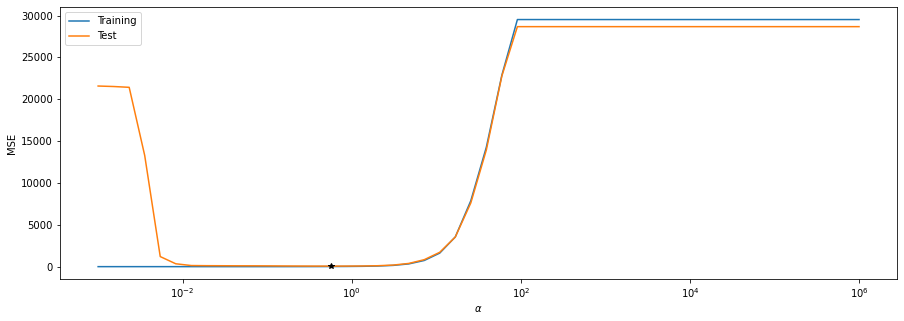

In [10]:
plt.semilogx(alpha_vec, mse_tr, label="Training")
plt.semilogx(alpha_vec, mse_te, label="Test")

i_opt = np.argmin(mse_te)
plt.semilogx(alpha_vec[i_opt], mse_te[i_opt], "k*")

plt.xlabel("$\\alpha$")
plt.ylabel("MSE")
plt.legend()
plt.show()

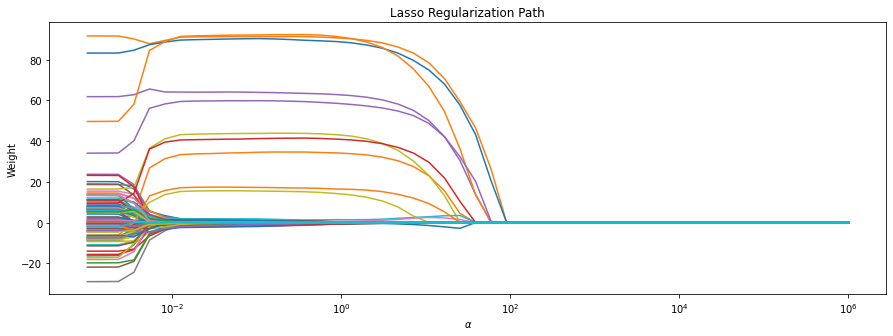

In [11]:
plt.semilogx(alpha_vec, coefs)

plt.title("Lasso Regularization Path")
plt.xlabel("$\\alpha$")
plt.ylabel("Weight")
plt.show()

This cell computes the "theoretical" regularization path of Lasso.

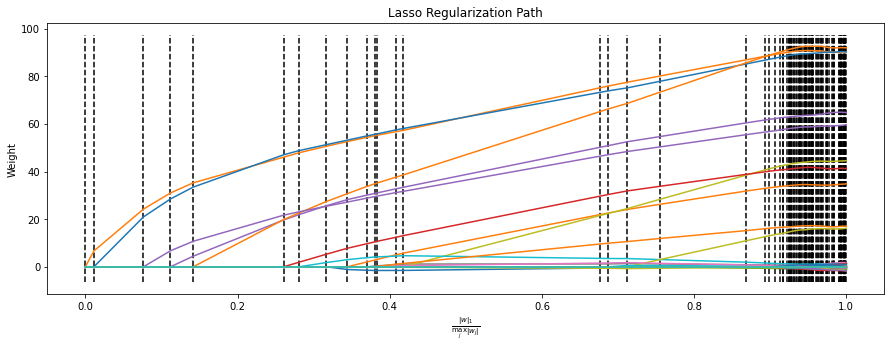

In [12]:
_, _, coefs = lars_path(X_tr, y_tr, method="lasso")

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")

plt.title("Lasso Regularization Path")
plt.xlabel("$\\frac{\\|w\\|_1}{\\max_j\\|w_j\\|}$")
plt.ylabel("Weight")
plt.axis("tight")
plt.show()

### Cross-Validation

An automatic search of the parameters can be done using the `GridSearchCV` function.

In [17]:
gs_la = GridSearchCV(Lasso(max_iter=5000), cv=5, param_grid={"alpha": alpha_vec})
gs_la.fit(X_tr, y_tr)
print("Best Parameter: %.2g" % gs_la.best_params_["alpha"])

Best Parameter: 0.16


The selected features can be inspected in the optimum model.

In [18]:
print(gs_la.best_estimator_.sparse_coef_)

  (0, 0)	0.32353745511291604
  (0, 1)	91.28833414513625
  (0, 3)	-1.6281375426354647
  (0, 4)	63.8155258586571
  (0, 5)	-0.9721049529710574
  (0, 6)	-0.0031634995615658387
  (0, 7)	0.024329210848959285
  (0, 10)	1.0199959461946715
  (0, 11)	0.202667358150038
  (0, 14)	-0.17204042907073677
  (0, 15)	0.14523793502007776
  (0, 16)	0.4163191364716868
  (0, 17)	0.7723857757014284
  (0, 18)	-0.1317525698766256
  (0, 21)	34.644860258666036
  (0, 23)	0.42638473525629
  (0, 25)	0.5908131759880678
  (0, 26)	0.2613857601250035
  (0, 27)	-0.16635717534957037
  (0, 28)	0.4735994414618971
  (0, 29)	-0.4774101562365436
  (0, 30)	90.19016272801427
  (0, 32)	-0.6414508703215361
  (0, 33)	-0.23518018681634356
  (0, 34)	0.1000223421043725
  :	:
  (0, 50)	0.09399393131130193
  (0, 52)	0.9519142380272441
  (0, 53)	-0.6513734071890982
  (0, 54)	-0.11730198515443413
  (0, 56)	0.5320740659748804
  (0, 57)	-0.6346440118211566
  (0, 58)	-0.2556188994446533
  (0, 59)	0.9491024643584696
  (0, 60)	-1.7059047819591

<div class="qst">

* Is there any sparsity?

</div>

## Elastic-Net

For Elastic-Net, two hyper-parameters have to be set, and hence plotting a regularization path is not trivial.

In [19]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

gs_en = GridSearchCV(ElasticNet(max_iter=5000), cv=5,
                  param_grid={"alpha": alpha_vec, "l1_ratio": [0, 0.05, 0.5, 0.95, 1.0]})
gs_en.fit(X_tr, y_tr)
print("Best Regularization Parameter: %.2g" % gs_en.best_params_["alpha"])
print("Best Mixture Parameter: %.2g" % gs_en.best_params_["l1_ratio"])

Best Regularization Parameter: 0.16
Best Mixture Parameter: 1


The results of the three models can be compared with the following cell.

In [20]:
print("Ridge Regression: %.4f" % gs_rr.score(X_te, y_te))
print("Lasso:            %.4f" % gs_la.score(X_te, y_te))
print("Elastic-Net:      %.4f" % gs_en.score(X_te, y_te))

Ridge Regression: 0.4602
Lasso:            0.9972
Elastic-Net:      0.9972


<div class="qst">

* Which model is better?
* Is in this case Elastic-Net different from Lasso? Why?

</div>